# Introduction



# Table of Contents

In [2]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

# Methods
Mathods Explanations

## The Dataset
The dataset isn't .........

In [7]:
df = pd.read_json("/data/processed/processed.csv")
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


I picked five random records from the dataframe for a later visiual inspection of predictions. I dropped these records from the original dataframe by aiming to prevent the model to be trained on them.

In [8]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [9]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

Here, you can see a sample image from the dataset with a bounding box over the license plate.

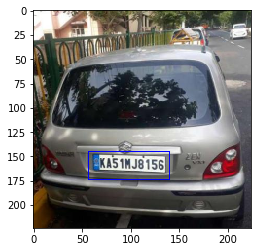

In [10]:
show_img(5)

I created an `ImageDataGenerator` object from Keras to load batches of images to memory. This process is necessary because we do not have infinite memory in both RAM and GPU RAM. I splitted the data into two with a batch size of 32 images. One for training (80% of the data) and one for validation (20% of the data) during training. Validation is important to see if the model overfit to the training data.

## The Model

I created a relatively "not so deep" convolutional neural network. It have 8 convolutinal layers with 4 max pool layers and a fully connected network with 2 hidden layers.

In [12]:
model = load_model("models/model.h5")
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14

To find the minimum amount of step count to cover all the batches, the following equations are necessary. Mathematically;

$$
\text{Step size} = \lceil \frac{\text{Number of elements}}{\text{Batch Size}} \rceil
$$

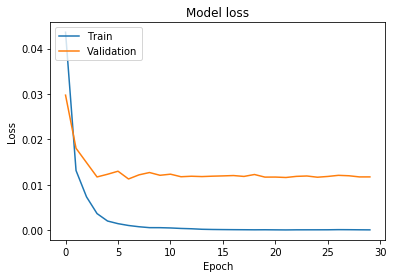

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model's success over the validation data is 80%. However, you can see that from the above figure, the training is stopped after 30th epoch. This may because of the low number of training samples or my model is not capable of learning such data. If you have an idea, please comment below.

## Tests

In [17]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

0.011739849112927914

Remember that, we had picked five lucky test samples for visiual inspection. Here they are.

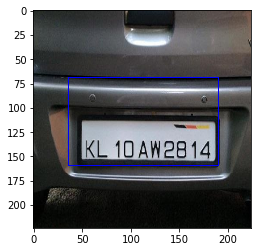

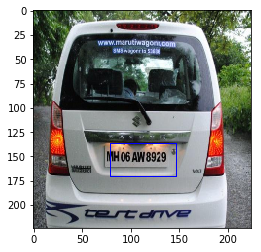

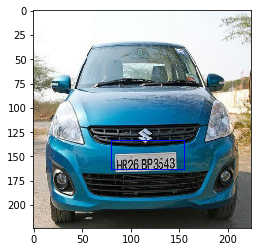

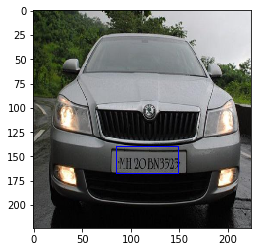

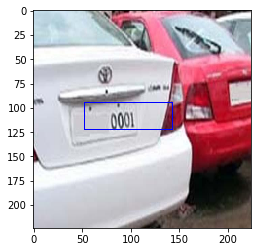

In [18]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Indian Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

# Conclusion
The model defined above is a very simple toy model. The training is straightforward and tests may not be reliable since the dataset is so small. However, it proves a concept that you can find plates from images with a simple CNN. This network may be used as a part of other more complicated networks.

Thank you :)